In [8]:
'''
Importing the necessary libraries and modules.
The dataset file is located in a local directory
'''

'''
Importing libraries and loading dataset
should be hosted in different cells for 
the sake of convenience.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Text
from matplotlib.ticker import FuncFormatter
import seaborn as sns


from scipy.stats import shapiro, mannwhitneyu, ttest_ind, zscore, probplot

from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

In [9]:
## Load dataset from local directory
file_path = './ESS2e03_6.csv'
df = pd.read_csv(file_path, encoding='latin1', low_memory=False)

## Numerical metrics (if any)
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
essround,47537.0,2.000000e+00,0.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000e+00
edition,47537.0,3.600000e+00,8.881878e-16,3.600000,3.600000,3.600000,3.600000,3.600000e+00
idno,47537.0,1.685002e+07,9.046804e+07,1.000000,1459.000000,3706.000000,47885.000000,9.214130e+08
tvtot,47537.0,4.557019e+00,5.063879e+00,0.000000,3.000000,4.000000,6.000000,9.900000e+01
tvpol,47537.0,4.236174e+00,1.234226e+01,0.000000,1.000000,2.000000,2.000000,9.900000e+01
...,...,...,...,...,...,...,...,...
supqmm,44463.0,9.575557e+00,1.370726e+01,1.000000,2.000000,10.000000,11.000000,9.900000e+01
supqyr,45961.0,2.123905e+03,9.700956e+02,2004.000000,2004.000000,2004.000000,2005.000000,9.999000e+03
dweight,47537.0,9.999963e-01,4.733246e-01,0.001600,0.835500,1.000000,1.055600,5.983300e+00
pspwght,47537.0,1.000244e+00,5.586856e-01,0.001502,0.661499,0.919958,1.194815,6.274307e+00


## Foreword
- Before we analysed this whole thing, we selected only some of the columns that are the most related to 'health' through **2 correlation tests**.
- The dataset is so huge *(600 columns x 45k rows, non-weighted values included, no NaN)* that it will take some time for the kendall correlation test to run (more than 10 minutes for me so I didn't do it).
- We didn't have time to look at the dataset with a scientific approach, so we decided to only stick to what we've learnt from the course and add a touch of our own approach. 
- It is also in our realization that the dataset we chose only contains **scaled discrete values / datapoints** (Likert scale, Rating scale,...), so it was very challenging (for us) to perform any analysis worth notetaking.
- If the columns' name doesn't make any sense, it doesn't for us as well. You can find the dataset's variable list [here](https://www.europeansocialsurvey.org/sites/default/files/2023-06/ESSDE1-7e01_variable_list.pdf) or you can access the dataset via [this link](https://ess.sikt.no/en/datafile/edee45f2-976b-4c8b-902d-b65dc003c92e). The necessary links will be attached when needed in the notebook.

### Overall health status of Europe

- In this step, we analysed the subjective health (self viewpoint towards personal health) of Europeans.
- You can access the list of country's abbreviation via [this link](https://ess.sikt.no/en/datafile/edee45f2-976b-4c8b-902d-b65dc003c92e/58?tab=1&elems=a4f38e56-a129-43c2-a8fc-bb936ad01847_1)

Mean: 2.24
Median: 2.00
Standard deviation: 0.93
Minimum: 1
Maximum: 5
Skewness: 0.52


count    47459.00000
mean         2.23987
std          0.93069
min          1.00000
25%          2.00000
50%          2.00000
75%          3.00000
max          5.00000
Name: health, dtype: float64

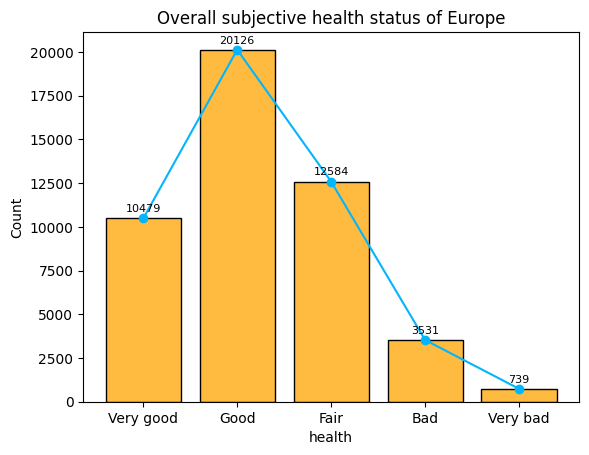

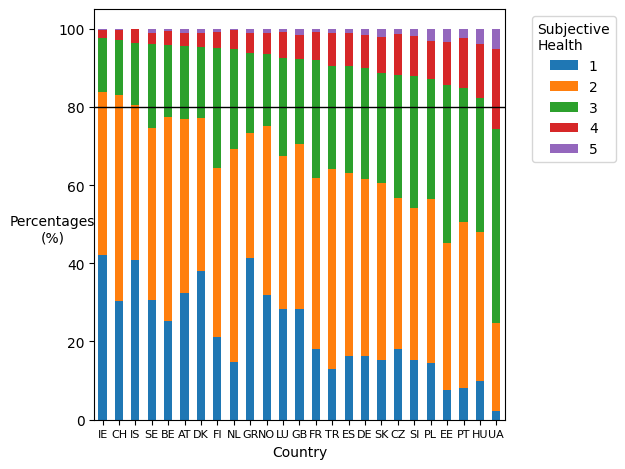

In [10]:
## Overall health status of Europe (2004)

## Some basic metrics of Europe's subjective health status
## The health status is rated from 1 to 5, where 1 is 'Very good' and 5 is 'Very bad'
## The health status is subjective, and the rating is based on the individual's own perception of their health.

data = df[df['health'] < 6]['health'].dropna()
print(f"Mean: {data.mean():.2f}")
print(f"Median: {data.median():.2f}")
print(f"Standard deviation: {data.std():.2f}")
print(f"Minimum: {data.min()}")
print(f"Maximum: {data.max()}")
print(f"Skewness: {data.skew():.2f}")

## OR

display(data.describe())

## Graphing the distribution of the health status over all Europe

rankings, healthiness = range(1, 6), ['Very good', 'Good', 'Fair', 'Bad', 'Very bad']

## Normality 'test' using histogram plot.
sns.histplot(data = data, color='orange',
             shrink=0.8, discrete = True)
plt.plot(range(1, 6), data.value_counts().sort_index(), color='#03b5fc', marker='o')
for i, j in zip(range(1, 6), data.value_counts().sort_index()):
    plt.text(i, j + 250, f'{j}', ha='center', va='bottom', fontsize=8)

plt.xticks(rankings, healthiness)
plt.title('Overall subjective health status of Europe')

'''
Although the rating is subjective (each person has a different
subjective viewpoint), the overall health status of Europe is concentrated
around 1-3, which is, in general, very healthy.

An interesting point is that for every country, the health status will
reach at least 80% of the population rating their health as Fair or better.
And the percentage of people rating their health being Bad and Very bad is
correlated with each other.
'''

counts = df[df['health'] < 7].groupby(['cntry', 'health']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

high_health_pct = percentages[range(1, 4)].sum(axis=1)
sort_order = high_health_pct.sort_values(ascending=False).index

percentages = percentages.loc[sort_order]

percentages.plot(kind='bar', stacked=True)

plt.ylabel('Percentages\n(%)', rotation = 0, va='top', ha='center')
plt.xlabel('Country')
plt.xticks(rotation=0, fontsize=8)

plt.axhline(y = 80, color='black', linestyle='-', linewidth=1)

plt.legend(title='Subjective\nHealth', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()



### Another attempt at visualizing each country's subjective health status
- We used a boxplot to represent the health status of each country. 
- For comparision, this is not a good representation since the data is discrete, hence making the boxplot blocky and does not give away too much insight. But it can still depicts a handful of information like outliers, mean and such...
- The second boxplot is just purely for fun. It is just the histogram plot above but with less information ;)

<Axes: ylabel='health'>

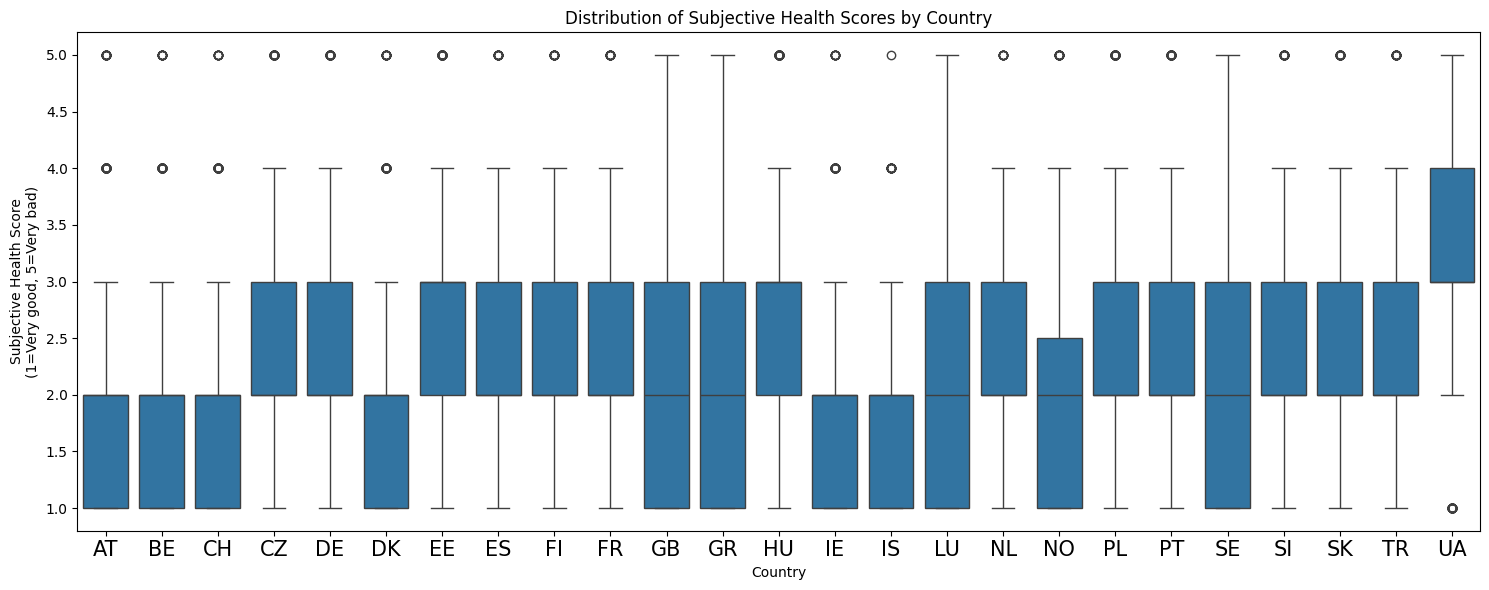

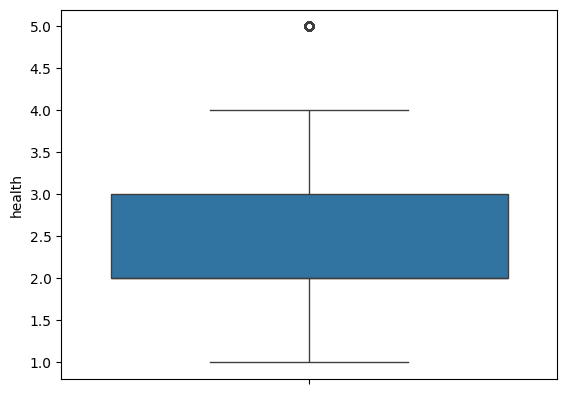

In [11]:
## Below is a boxplot of the subjective health status of each country.
## The boxplot is a good way to visualize the distribution of the data.

plt.figure(figsize=(15, 6))
sns.boxplot(data=df[df['health'] < 6], x='cntry', y='health')
plt.xticks(rotation=0, fontsize=15)
plt.xlabel('Country')
plt.ylabel('Subjective Health Score\n(1=Very good, 5=Very bad)')
plt.title('Distribution of Subjective Health Scores by Country')
plt.tight_layout()

## And this is just a big boxplot of the subjective health status of all Europe
## From the boxplot we can see that the distribution of the health status is not normal.
## The median is around 2, which means that most people rate their health as good or very good.


## This is purely for funsies
plt.figure()
sns.boxplot(data=df[df['health'] < 6], y='health')


---

### Filter out variables that are most likely to affect an individual sense of healthiness 

In this step, we wanted to find the most influenced variable to 'health' and how it correlates with each other

---

### What I did

- **Target variable**: We are focusing on analyzing the 'health' column, i.e. what would affect one person's sense of healthiness.
- **Correlation test**: We used 2 different correlation index methods (Pearson and Spearman) to find which variable within the dataset is likely to have a strong positive/negative link towards the healthiness scale <span style="color:red">**\***</span>
- **Statistical Visualization**: To confirm that there is (somewhat) a link between each "*healthiness - variable*" pair, the relation can be seen through a heatmap, stripplot or a *swarmplot* <span style="color:red">**\****</span>.


<span style="color:red">**\***</span>: The test only roughly depicts the full picture since we haven't filtered out the unweighted answer (i.e. 7: Don't know, 8: Don't want to answer,...) But for rechecking, once we obtained the correlations, we did a double check on the dataset to ensure that the unweighted answers covers less than 1% of the surveyers.

<span style="color:red">**\****</span>: A swarmplot wasn't used since the dataset was too big, but the same result could be observed when resampling the data to a smaller value (i.e. ~1000-3000)

---

### Summary table
| Step | What we chose | Why |
|------|--------------|-----|
| Correlation Test | Pearson and Spearman | The two methods are the fastest in runtime and is adequate to filter out high-correlation variable|
| Statistical Visualization | Heat map and/or Strip plot | Both of which can display how discrete datapoints spread in space, and in correlation. |

---

In [12]:
## Wanted to see which variables are correlated with health most
correlation = df.corr(numeric_only=True)['health']

In [13]:
## Filter out correlations that is significant with health

print("Top 5 strongest positive correlation to health, according to the dataset:\n",
      correlation.sort_values(ascending=False).head(6))

print()
print("Top 5 strongest negative correlation to health, according to the dataset:\n",
      correlation.sort_values(ascending=True).head(5))


Top 5 strongest positive correlation to health, according to the dataset:
 health     1.000000
actvgrs    0.394656
tmcnsdc    0.360070
gdsprt     0.358119
rtrd       0.338638
lfintr     0.301511
Name: health, dtype: float64

Top 5 strongest negative correlation to health, according to the dataset:
 hlthhmp   -0.416722
rtryr     -0.280256
wntrtr    -0.279271
clhwkrc   -0.267854
pdjobev   -0.262884
Name: health, dtype: float64


In [14]:
## Use a different method to calculate correlation
## Will take a while to run.

## On Kien's PC, it's around 3 minutes to process the
## correlation matrix using spearman's method.

correlation2 = df.corr(method = 'spearman', 
                       numeric_only = True,
                       )['health']

In [15]:
## Filter out the top 10, positive and negative
print("Top 5 strongest positive correlation to health, according to the dataset:\n",
      correlation2.sort_values(ascending=False).head(6))

print()
print("Top 5 strongest negative correlation to health, according to the dataset:\n",
      correlation2.sort_values(ascending=True).head(5))

Top 5 strongest positive correlation to health, according to the dataset:
 health     1.000000
agea       0.385878
actvgrs    0.370464
tmcnsdc    0.363149
rtrd       0.340615
gdsprt     0.339642
Name: health, dtype: float64

Top 5 strongest negative correlation to health, according to the dataset:
 hlthhmp   -0.525245
edlvgr    -0.476925
edlvpt    -0.472285
usmdprs   -0.384314
yrbrn     -0.380614
Name: health, dtype: float64


In [16]:
## The selected columns would contribute to the analysis of the dataset.

print("Top 10 strongest positive correlation to health, both methods:")
print(correlation.sort_values(ascending=False).head(10).index.tolist())
print(correlation2.sort_values(ascending=False).head(10).index.tolist())
## Although the two methods are different, they yield similar results.

correlation_list_pos_1 = correlation.sort_values(ascending=False).head(10).index.tolist()
correlation_list_pos_2 = correlation2.sort_values(ascending=False).head(10).index.tolist()

common_pos_correlation = [item for item in correlation_list_pos_1 if item in correlation_list_pos_2]

print()
print("Top 10 strongest negative correlation to health, both methods:")
print(correlation2.sort_values(ascending=True).head(10).index.tolist())
print(correlation.sort_values(ascending=True).head(10).index.tolist())
## Same goes with the negative correlations.

print()
correlation_list_neg_1 = correlation.sort_values(ascending=True).head(10).index.tolist()
correlation_list_neg_2 = correlation2.sort_values(ascending=True).head(10).index.tolist()

common_neg_correlation = [item for item in correlation_list_neg_1 if item in correlation_list_neg_2]

print("Both correlation list shares the following columns:\n")
print(common_pos_correlation, '\n', common_neg_correlation)
## The selected columns would contribute to the analysis of the dataset.
selected_columns = common_pos_correlation + common_neg_correlation

print()
print("The selected / filtered columns are: ", selected_columns)

## Analysis dataframe
filtered_df = df[selected_columns]  

print()
print(f"The correlation score of each column of each method is (excluding 'health'):")
for i, col in enumerate(selected_columns):
    print(f"{i + 1}. {col}: {correlation[col]:.2f} and {correlation2[col]:.2f}")

display(filtered_df.describe())
print('\n' * 3)

## Some first few lines of the newly filtered dataframe
display(filtered_df.head(10))

print("\nThe last step is to filter out the meaningful values of each column.")
print("There are non-weight values in the survey (i.e. 7 being 'Don't know', 8 being 'No answer',...")
print("We have to filter these value as NaN and process them accordingly")



## The meaning of the abbreviated column names
## can be found on the ESS website:
## https://ess.sikt.no/en/datafile/edee45f2-976b-4c8b-902d-b65dc003c92e
## OR the ESS vairable list:
## https://www.europeansocialsurvey.org/sites/default/files/2023-06/ESSDE1-7e01_variable_list.pdf


Top 10 strongest positive correlation to health, both methods:
['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr', 'clmrlx', 'frshrst', 'icmnac', 'plnchld']
['health', 'agea', 'actvgrs', 'tmcnsdc', 'rtrd', 'gdsprt', 'icag45y', 'moalv', 'faalv', 'lfintr']

Top 10 strongest negative correlation to health, both methods:
['hlthhmp', 'edlvgr', 'edlvpt', 'usmdprs', 'yrbrn', 'stflife', 'happy', 'netuse', 'rtryr', 'clhwkrc']
['hlthhmp', 'rtryr', 'wntrtr', 'clhwkrc', 'pdjobev', 'clfncrc', 'pdwrk', 'cldnhhn', 'usmdprs', 'edlvie']

Both correlation list shares the following columns:

['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr'] 
 ['hlthhmp', 'rtryr', 'clhwkrc', 'usmdprs']

The selected / filtered columns are:  ['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr', 'hlthhmp', 'rtryr', 'clhwkrc', 'usmdprs']

The correlation score of each column of each method is (excluding 'health'):
1. health: 1.00 and 1.00
2. actvgrs: 0.39 and 0.37
3. tmcnsdc: 0.36 and 0.36
4. gdspr

,health,actvgrs,tmcnsdc,gdsprt,rtrd,lfintr,hlthhmp,rtryr,clhwkrc,usmdprs
count,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000
mean,2.249637,3.017166,2.627658,2.794876,0.244504,2.925300,2.717315,5699.928140,4.789848,1.619181
std,0.960804,1.395300,1.337249,1.282396,0.429797,1.431319,0.709057,2007.813161,1.668850,0.638952
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,3.000000,6666.000000,3.000000,1.000000
50%,2.000000,3.000000,2.000000,2.000000,0.000000,3.000000,3.000000,6666.000000,6.000000,2.000000
75%,3.000000,4.000000,3.000000,3.000000,0.000000,4.000000,3.000000,6666.000000,6.000000,2.000000
max,9.000000,9.000000,9.000000,9.000000,1.000000,9.000000,9.000000,9999.000000,9.000000,9.000000


,health,actvgrs,tmcnsdc,gdsprt,rtrd,lfintr,hlthhmp,rtryr,clhwkrc,usmdprs
0,2,3,3,3,0,3,3,6666,6,2
1,3,4,4,4,1,4,2,1982,3,1
2,2,4,3,3,0,5,3,6666,6,2
3,1,3,2,2,0,2,3,6666,6,2
4,1,3,2,2,0,5,3,6666,6,2
5,2,3,2,3,0,2,3,6666,2,2
6,3,4,1,4,0,6,2,6666,6,2
7,2,3,2,2,0,3,3,6666,6,2
8,2,4,4,3,0,2,3,6666,6,2
9,1,2,2,1,0,1,3,6666,6,2



The last step is to filter out the meaningful values of each column.
There are non-weight values in the survey (i.e. 7 being 'Don't know', 8 being 'No answer',...
We have to filter these value as NaN and process them accordingly


---

### The effect of being hampered by illnesses towards the self-sense of healthiness

In this step, we analyzed the affects of an individual's **ableness** (can be changed) towards one's **sense of healthiness**.

*Note that*: This 'health' scale doesn't mean that a person is objectively healthy, but rather how they feel healthy subjectively.

---

#### What we did

- Saved the column information into dynamic variables, so that it can be changed later easily.
- Used the method stated above (Heat-map and/or Strip-plot)

---

 

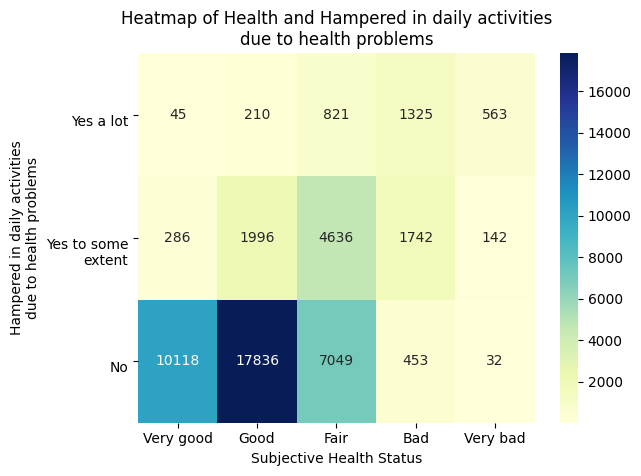

'\nThe heatmap shows that people who are opted to not be hindered by illnesses\nare more likely to rate their health as "very good" or "good".\n'

In [17]:
## The dataset suggests that 'health' is surveyed on a scale of 1-5
## And 'hlthhmp' or "Hampered in daily activities by illness/disability/infirmity/mental problem" is surveyed on a scale of 1-3
## In both cases, 1 being the best (healthiest / most active) and 1 being the worst (was hindered, alot).

'''
This variable was chosen since it's the only top 10 correlated variable that also
appears in the new dataset further in the finding (ESS11, 2023).

Preivously, the 'actvgrs' or 'feelings of being active and vigorous' was chosen.
But it was not present in the new dataset. 

Regardless of the variable chosen, the analysis is (roughly) the same.
The only difference is how the Linear Regression model is trained and/or perform.
'''

target_col = 'hlthhmp'
target_col_labels = ["Yes a lot", "Yes to some\nextent", "No"]
target_col_meaning = "Hampered in daily activities\ndue to health problems"

combined_df = filtered_df[['health', target_col]].dropna()
clean_df = combined_df[(combined_df['health'] < 6) & (combined_df[target_col] <= len(target_col_labels))] 

sns.heatmap(pd.crosstab(clean_df[target_col], clean_df['health']), annot=True, cmap='YlGnBu', fmt='d')
plt.title(f"Heatmap of Health and {target_col_meaning}")
plt.ylabel(target_col_meaning)
plt.xlabel("Subjective Health Status", rotation=0)
plt.yticks(np.arange(len(target_col_labels)) + 0.5, labels=target_col_labels, rotation = 0, ha='right', va='top')
plt.xticks(np.arange(5) + 0.5, ['Very good', 'Good', 'Fair', 'Bad', 'Very bad'])
plt.show()

'''
The heatmap shows that people who are opted to not be hindered by illnesses
are more likely to rate their health as "very good" or "good".
'''



'\n\nFrom the stripplot we can see that there is (roughly) a linear correlation between the two variables.\nThe less hindered by physical / mental illness a person, the better they rate their health.\n'

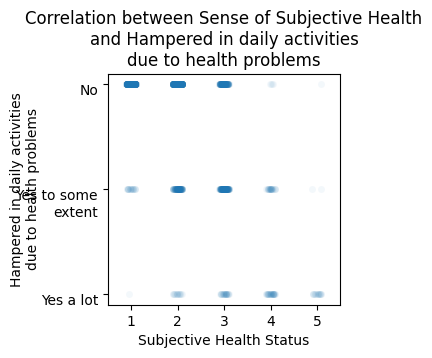

In [ ]:
'''
This can also be visualized through a scatter plot with
overlapping points spreaded in a sense that there are many
points overlapping at the same location.
'''

plt.figure(figsize = (3, 3))
sns.stripplot(x='health', y=target_col, data=clean_df.iloc[:2000], alpha=0.05, size=5)
plt.title(f"Correlation between Sense of Subjective Health\nand {target_col_meaning}")
plt.yticks(np.arange(len(target_col_labels)) + 1, labels=target_col_labels, rotation = 0, ha='right', va='top')
plt.xlabel("Subjective Health Status")
plt.ylabel(target_col_meaning, rotation = 90, va='top', ha='center')
'''

From the stripplot we can see that there is (roughly) a linear correlation between the two variables.
The less hindered by physical / mental illness a person, the better they rate their health.

I am sorry I don't know how to format the figure in order for it to be beautiful :)) - Kien
I am also clueless - Roberto

'''


### Conclusion:
- From what we've seen above, it is safe to conclude that people who is not hindered by any physical / mental illness will tend to feel a healthier lifestyle.
- Although the trend is not as visual as ones with continuous data, it still poses noticeable trends where the selected variable correlates (somewhat) strongly with subjective health.

---
### Now moving on to
---
## Predictive Analysis 

In this step, the current data (ESS round 2, 2004) will be used to perform a predictive analysis and compare the results to more recent ESS dataset (i.e. ESS round 11, 2023)

---
### What we did
- We used the **filtered Data Frame** to train a Linear Regression model on predicting a person's subjective health based on the <span style="color:rgb(252, 190, 3)">**correlated variables**</span>
- Compute the predictions through the trained model using the **more recent dataset** and compare the output with the actual data, visualize the differences through a **residual plot**.

---


Basic metrics of the model's residuals (compared to real data):

Mean: -0.01
Median: 0.05
Max: 2.05, min: -2.70
Variance: 0.66
Standard deviation: 0.81
Mean absolute error: 0.59

Basic metrics of the model's predictions (compared to real data):

Mean: 3.14
Max: 3.70, min: 2.95
Variance: 0.11
Standard deviation: 0.32
Mean absolute error: 0.59


<Axes: xlabel='health', ylabel='Count'>

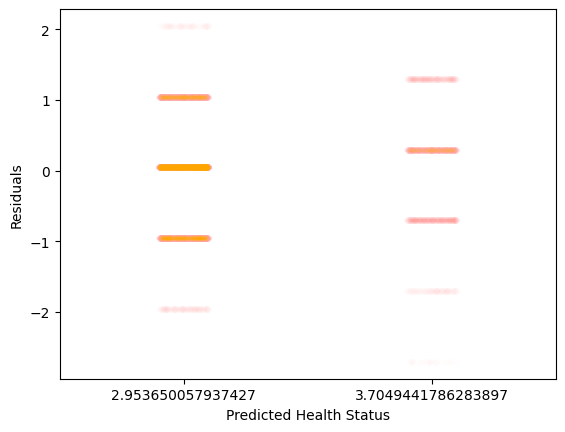

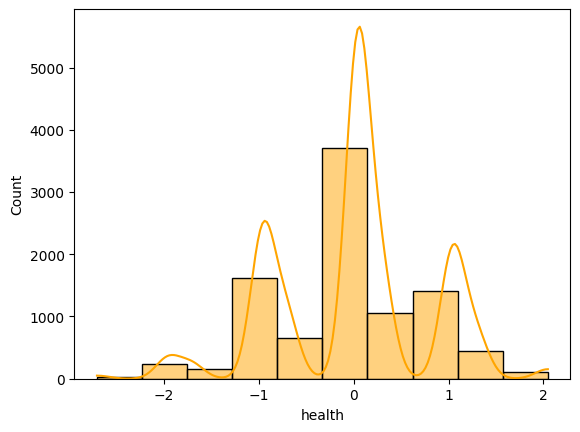

In [19]:
# Copy to a new data frame
input_data = df[[target_col]]
output_data = df['health']

# Remove non-weighted values and possible NaN values
combined = pd.concat([input_data, output_data], axis=1)
combined = combined[(combined[target_col] < len(target_col_labels)) & (combined['health'] < 6)]
combined = combined.dropna()

input_data = combined[[target_col]]
output_data = combined['health']

## Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.8, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

## Reults of the model
## Since our data is descrete, we can round the 
## model's predictions to the nearest integer to get 
## a more accurate prediction.

## Rouding is optional, but it helps to visualize the results better.
y_prediction = model.predict(x_test)
# y_prediction = np.round(y_prediction)
residual = y_test - y_prediction
# residual = y_prediction # <- Use this when you want to see y_prediction metrics



print(f"Basic metrics of the model's residuals (compared to real data):\n")
print(f"Mean: {residual.mean():.2f}")
print(f"Median: {residual.median():.2f}")
print(f"Max: {residual.max():.2f}, min: {residual.min():.2f}")
print(f"Variance: {residual.var():.2f}")
print(f"Standard deviation: {residual.std():.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_prediction):.2f}")

print(f"\nBasic metrics of the model's predictions (compared to real data):\n")
print(f"Mean: {y_prediction.mean():.2f}")
print(f"Max: {y_prediction.max():.2f}, min: {y_prediction.min():.2f}")
print(f"Variance: {y_prediction.var():.2f}")
print(f"Standard deviation: {y_prediction.std():.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_prediction):.2f}")

## Below is the residual plot of the model
## But since it's a discrete dataset, the residual plot is best 
## visualized using a stripplot with a small alpha value.

## The data contains 45k+ rows so by setting the alpha small
## enough, we can see the distribution of the residuals.

plt.figure()
sns.stripplot(x=y_prediction, y=residual, alpha=0.002, color='orange')
plt.xlabel("Predicted Health Status")
plt.ylabel("Residuals")
### Can't find a way to format the x-axis ticks to be .2f :(((

## And this residual = y_test - y_prediction can be plotted using a histogram as well
## 
plt.figure()
sns.histplot(residual, color='orange', kde=True, binwidth=0.5)


### Comment about the model
The trained model is (safe to say) pretty accurate with a mean of 0.01 and a variance of 0.71.

In [20]:
## Now let's see how well the model performs
## when we give it a new set of data.

## Bear in mind that the new set of data is only similar but not identical to the old one.
## And the new set of data is measured not in the same set of countries as the old one.
## The new set of data is from the ESS 11th round (2023) and the old one is from the 2nd round (2004).

## Load the new dataset 
file_path = './ESS11.csv'
new_df = pd.read_csv(file_path, encoding='latin1', low_memory=False)

## Numerical metrics (if any)
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
essround,47537.0,2.000000e+00,0.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000e+00
edition,47537.0,3.600000e+00,8.881878e-16,3.600000,3.600000,3.600000,3.600000,3.600000e+00
idno,47537.0,1.685002e+07,9.046804e+07,1.000000,1459.000000,3706.000000,47885.000000,9.214130e+08
tvtot,47537.0,4.557019e+00,5.063879e+00,0.000000,3.000000,4.000000,6.000000,9.900000e+01
tvpol,47537.0,4.236174e+00,1.234226e+01,0.000000,1.000000,2.000000,2.000000,9.900000e+01
...,...,...,...,...,...,...,...,...
supqmm,44463.0,9.575557e+00,1.370726e+01,1.000000,2.000000,10.000000,11.000000,9.900000e+01
supqyr,45961.0,2.123905e+03,9.700956e+02,2004.000000,2004.000000,2004.000000,2005.000000,9.999000e+03
dweight,47537.0,9.999963e-01,4.733246e-01,0.001600,0.835500,1.000000,1.055600,5.983300e+00
pspwght,47537.0,1.000244e+00,5.586856e-01,0.001502,0.661499,0.919958,1.194815,6.274307e+00


Mean: 2.15
Median: 2.00
Standard deviation: 0.91
Minimum: 1
Maximum: 5
Skewness: 0.55


count    40103.000000
mean         2.146573
std          0.907145
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: health, dtype: float64

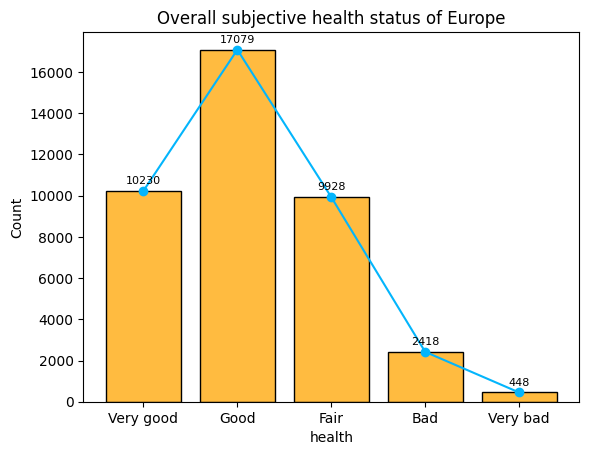

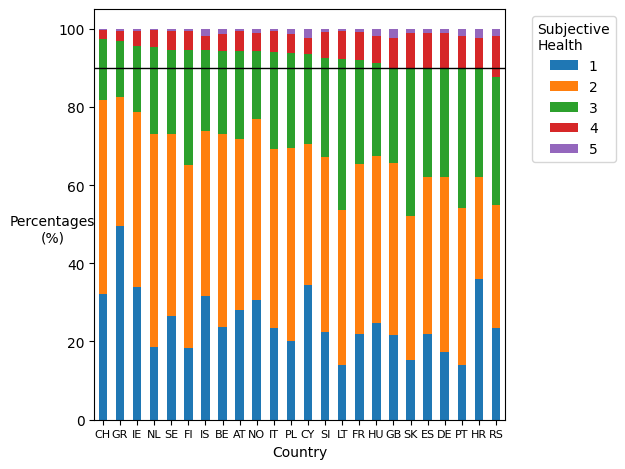

In [21]:
## Overall health status of Europe (2023)

## This cell is a copy of a previous cell in this file.
## Only difference is that the dataset is different.

## Some basic metrics of Europe's subjective health status
## The health status is rated from 1 to 5, where 1 is 'Very good' and 5 is 'Very bad'
## The health status is subjective, and the rating is based on the individual's own perception of their health.

data = new_df[new_df['health'] < 6]['health'].dropna()
print(f"Mean: {data.mean():.2f}")
print(f"Median: {data.median():.2f}")
print(f"Standard deviation: {data.std():.2f}")
print(f"Minimum: {data.min()}")
print(f"Maximum: {data.max()}")
print(f"Skewness: {data.skew():.2f}")

## OR

display(data.describe())

## Graphing the distribution of the health status over all Europe

rankings, healthiness = range(1, 6), ['Very good', 'Good', 'Fair', 'Bad', 'Very bad']

## Normality 'test' using histogram plot.
sns.histplot(data = data, color='orange',
             shrink=0.8, discrete = True)
plt.plot(range(1, 6), data.value_counts().sort_index(), color='#03b5fc', marker='o')
for i, j in zip(range(1, 6), data.value_counts().sort_index()):
    plt.text(i, j + 250, f'{j}', ha='center', va='bottom', fontsize=8)

plt.xticks(rankings, healthiness)
plt.title('Overall subjective health status of Europe')

'''
Although the rating is subjective (each person has a different
subjective viewpoint), the overall health status of Europe is concentrated
around 1-3, which is, in general, very healthy.

An interesting point is that for every country, the health status will
reach at least 80% of the population rating their health as Fair or better.
And the percentage of people rating their health being Bad and Very bad is
correlated with each other.
'''

counts = new_df[new_df['health'] < 7].groupby(['cntry', 'health']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

high_health_pct = percentages[range(1, 4)].sum(axis=1)
sort_order = high_health_pct.sort_values(ascending=False).index

percentages = percentages.loc[sort_order]

percentages.plot(kind='bar', stacked=True)

plt.ylabel('Percentages\n(%)', rotation = 0, va='top', ha='center')
plt.xlabel('Country')
plt.xticks(rotation=0, fontsize=8)

plt.axhline(y = 90, color='black', linestyle='-', linewidth=1)

plt.legend(title='Subjective\nHealth', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()



## Comment
- It can be seen that the percentage of people that felt "Fair" or above on their healthiness scale has now increased to near 90% for each country.
- And the fact that total people felt 'Bad' or worse has now decreased (which is a good-ish sign).

## Check the LinearRegression model training

## In this step, we will
- Compare the results of the Regression model when let it train on the new data (same variable) to the 'health' variable.

Basic metrics of the model's residuals (compared to real data):

Mean: -0.15
Median: 0.05
Max: 2.05, min: -2.70
Variance: 0.64
Standard deviation: 0.80
Mean absolute error: 0.59

Basic metrics of the model's outputs (compared to real data):

Mean: 3.13
Max: 3.70, min: 2.95
Variance: 0.10
Standard deviation: 0.32
Mean absolute error: 0.59


Text(0, 0.5, 'Count')

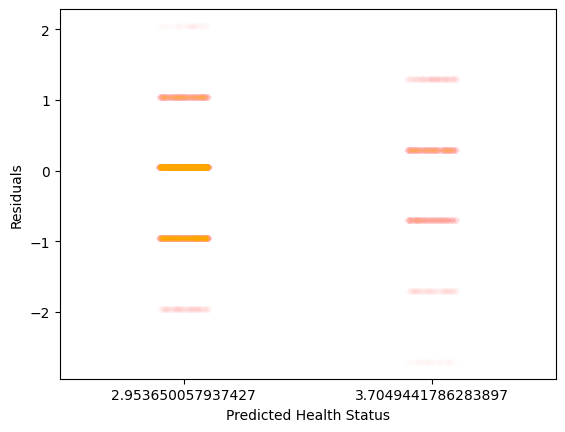

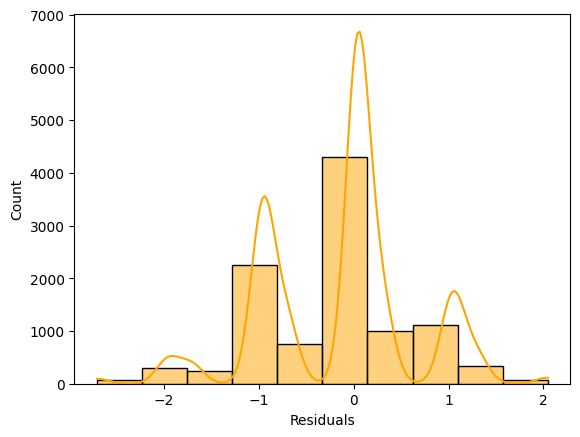

In [22]:
# Copy to a new data frame
input_data = new_df[[target_col]]
output_data = new_df['health']

# Remove non-weighted values and possible NaN values
combined = pd.concat([input_data, output_data], axis=1)
combined = combined[(combined[target_col] < len(target_col_labels)) & (combined['health'] < 6)]
combined = combined.dropna()

input_data = combined[[target_col]]
output_data = combined['health']

output_prediction = model.predict(input_data)
# output_prediction = np.round(output_prediction) 
residual = output_data - output_prediction
# residual = output_prediction # <- Use this when you want to see y_prediction metrics


print(f"Basic metrics of the model's residuals (compared to real data):\n")
print(f"Mean: {residual.mean():.2f}")
print(f"Median: {residual.median():.2f}")
print(f"Max: {residual.max():.2f}, min: {residual.min():.2f}")
print(f"Variance: {residual.var():.2f}")
print(f"Standard deviation: {residual.std():.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_prediction):.2f}")

print(f"\nBasic metrics of the model's outputs (compared to real data):\n")
print(f"Mean: {output_prediction.mean():.2f}")
print(f"Max: {output_prediction.max():.2f}, min: {output_prediction.min():.2f}")
print(f"Variance: {output_prediction.var():.2f}")
print(f"Standard deviation: {output_prediction.std():.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_prediction):.2f}")

sns.stripplot(x=output_prediction, y=residual, alpha=0.002, color='orange', jitter=True)
plt.xlabel("Predicted Health Status")
plt.ylabel("Residuals")

## And this residual = y_test - y_prediction can be plotted using a histogram as well

plt.figure()
sns.histplot(residual, color='orange', kde=True,
             binwidth=0.5)
plt.xlabel("Residuals")
plt.ylabel("Count")

## Afterword
- The stripplot means that where the data is more visually seen (visibility is darker), the more points are concentrated at that point.Which in turns, tells us that the error will likely be around 